In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
X = fetch_adult()
X

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


WeightedDataset(X=                   age     workclass     education  education-num  \
race      sex                                                       
Non-white Male    25.0       Private          11th            7.0   
White     Male    38.0       Private       HS-grad            9.0   
          Male    28.0     Local-gov    Assoc-acdm           12.0   
Non-white Male    44.0       Private  Some-college           10.0   
White     Male    34.0       Private          10th            6.0   
...                ...           ...           ...            ...   
          Female  27.0       Private    Assoc-acdm           12.0   
          Male    40.0       Private       HS-grad            9.0   
          Female  58.0       Private       HS-grad            9.0   
          Male    22.0       Private       HS-grad            9.0   
          Female  52.0  Self-emp-inc       HS-grad            9.0   

                      marital-status         occupation   relationship   race  \
rac

In [3]:
def load_adult():
    data_df = pd.read_csv(f"adult.csv")
    # Drop the target column
    TARGET_COLUMNS = data_df.columns[-1]
    data = data_df.drop(columns=[TARGET_COLUMNS])

    data, numeric_columns, categorical_columns = preprocess_dataset(data, continuous_features=[])
    data_df_copy = data.copy()
    # Scale the dataset
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(data_scaled, columns=data.columns)

    FEATURE_COLUMNS = data.columns

    # Add the target column back
    data[TARGET_COLUMNS] = data_df[TARGET_COLUMNS]

    return data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns

In [4]:
def preprocess_dataset(df, continuous_features=[]):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()

    numeric_columns = []
    categorical_columns = []

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if the column is categorical
        if df[col].dtype == 'object' or df[col].dtype == 'category' and col not in continuous_features:
            categorical_columns.append(col)
            # If the column has only two unique values, treat it as binary categorical
            if len(df[col].unique()) == 2:
                # Label encode binary categorical features
                df[col] = label_encoder.fit_transform(df[col])
            else:
                # One-hot encode regular categorical features
                encoded_values = onehot_encoder.fit_transform(df[[col]])
                # Create new column names for the one-hot encoded features
                new_cols = [col + '_' + str(i) for i in range(encoded_values.shape[1])]
                # Convert the encoded values to a DataFrame and assign column names
                encoded_df = pd.DataFrame(encoded_values.toarray(), columns=new_cols)
                # Concatenate the encoded DataFrame with the original DataFrame
                df = pd.concat([df, encoded_df], axis=1)
                # Drop the original categorical column from the DataFrame
                df.drop(col, axis=1, inplace=True)
        # If the column is numerical but in string format and not in continuous_features, convert it to numerical type
        elif df[col].dtype == 'object' or df[col].dtype == 'category' and df[
            col].str.isnumeric().all() and col not in continuous_features:
            df[col] = df[col].astype(int)  # Convert to integer type
            categorical_columns.append(col)
        # If the column is a continuous feature, discretize it into bins
        elif col in continuous_features:
            numeric_columns.append(col)
            # Calculate the number of bins
            num_unique_values = len(df[col].unique())
            value_range = df[col].max() - df[col].min()
            num_bins = calculate_num_bins(num_unique_values, value_range)

            # Discretize into bins
            bin_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
            bins = bin_discretizer.fit_transform(df[[col]])
            # Replace the original continuous feature with the binned values
            df[col] = bins.astype(int)
        else:
            # Here are numerical columns. If the column has only 2 unique values, dont add it to numeric_columns
            if len(df[col].unique()) > 2:
                numeric_columns.append(col)
    return df, numeric_columns, categorical_columns

In [5]:
data = load_adult()
data

(            age  workclass  education  education-num  marital-status  \
 0      0.301370      0.875   0.600000       0.800000        0.666667   
 1      0.452055      0.750   0.600000       0.800000        0.333333   
 2      0.287671      0.500   0.733333       0.533333        0.000000   
 3      0.493151      0.500   0.066667       0.400000        0.333333   
 4      0.150685      0.500   0.600000       0.800000        0.333333   
 ...         ...        ...        ...            ...             ...   
 48837  0.301370      0.500   0.600000       0.800000        0.000000   
 48838  0.643836      0.000   0.733333       0.533333        1.000000   
 48839  0.287671      0.500   0.600000       0.800000        0.333333   
 48840  0.369863      0.500   0.600000       0.800000        0.000000   
 48841  0.246575      0.625   0.600000       0.800000        0.333333   
 
        occupation  relationship  race  sex  capital-gain  capital-loss  \
 0        0.071429           0.2  1.00  1.0    

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def calculate_metrics_and_split_data(data, features, target, classifier_type='logistic_regression',
                                     metrics=['accuracy'], attribute=None, protected_attribute='sex'):
    """
    Train a classifier, predict on test data, calculate specified metrics from the confusion matrix,
    and optionally split the test data based on an attribute.

    :param data: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param classifier_type: Type of classifier ('logistic_regression', 'svm', 'random_forest', 'naive_bayes')
    :param metrics: List of metrics to calculate ('accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn')
    :param attribute: Optional attribute to split the test data on, which should be binary (0 or 1)
    :param protected_attribute: Name of the protected attribute to be removed from the feature set (default is 'sex')
    :return: Dictionary of requested metrics and optionally two DataFrames, one for each value of the attribute,
             and the trained model instance, and the preprocessor
    """
    # Step 1: Remove the protected attribute from the features
    features_without_protected = [col for col in features if col != protected_attribute]

    # Encode categorical features and scale numerical features
    categorical_features = data[features_without_protected].select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = data[features_without_protected].select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)],
        remainder='passthrough')  # Keep other columns that aren't categorized for transformation

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[features_without_protected], data[target], test_size=0.2, random_state=42)

    # Debugging: Print the shape of the train and test sets
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Initialize classifier
    classifiers = {
        'logistic_regression': LogisticRegression(max_iter=500, solver='saga'),
        'svm': SVC(probability=True),
        'random_forest': RandomForestClassifier(),
        'naive_bayes': GaussianNB()
    }
    classifier = classifiers[classifier_type]

    # Fit the classifier and predict
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]  # True Positives
    tn = cm[0, 0]  # True Negatives
    fp = cm[0, 1]  # False Positives
    fn = cm[1, 0]  # False Negatives

    # Debugging: Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics_dict = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

    # Print accuracy
    print(f"Accuracy: {metrics_dict['accuracy']}")

    # Validate metrics
    results = {}
    for metric in metrics:
        if metric not in metrics_dict:
            raise ValueError(
                f"Unsupported metric '{metric}'. Choose from 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn'.")
        results[metric] = metrics_dict[metric]

    # Step 3: Add the target and predictions back to the test set for completeness
    X_test_df = X_test.copy()
    X_test_df[target] = y_test.values
    X_test_df['pred'] = y_pred

    # Step 4: Separate True Negatives (TN) and False Negatives (FN)
    tn_df = X_test_df[(X_test_df[target] == 0) & (X_test_df['pred'] == 0)]  # True Negatives
    fn_df = X_test_df[(X_test_df[target] == 1) & (X_test_df['pred'] == 0)]  # False Negatives

    # Debugging: Print the test data with all columns (True Negatives)
    print("Test data with all columns (True Negatives):")
    print(tn_df.head())
    
    # Debugging: Print the test data with all columns (False Negatives)
    print("Test data with all columns (False Negatives):")
    print(fn_df.head())

    return results, X_test_df, pipeline, tn_df, fn_df

In [7]:
data, features, target, numeric_columns, categorical_columns = load_adult()


# Drop the 'sex' column from the data to ensure it doesn't get passed to the model
data = data.drop(columns=['sex'])

# Also ensure 'sex' is removed from the feature columns list
features = [col for col in features if col != 'sex']

# Print to verify that 'sex' is removed from both data and features
print("Columns in data after removing 'sex':", data.columns)
print("Features after removing 'sex':", features)

# Call the calculate_metrics_and_split_data function
results, X_test_df, trained_model_pipeline, tn_df, fn_df = calculate_metrics_and_split_data(
    data=data, 
    features=features, 
    target=target
)

# Print the shape and the first few rows of tn_df and fn_df to inspect them
print("Shape of tn_df (True Negatives):", tn_df.shape)
print("First few rows of tn_df:")
print(tn_df.head())

print("\nShape of fn_df (False Negatives):", fn_df.shape)
print("First few rows of fn_df:")
print(fn_df.head())

Columns in data after removing 'sex': Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss',
       'hours-per-week', 'target'],
      dtype='object')
Features after removing 'sex': ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Training data shape: X_train: (39073, 11), y_train: (39073,)
Testing data shape: X_test: (9769, 11), y_test: (9769,)
Confusion Matrix:
[[1023 1332]
 [ 397 7017]]
Accuracy: 0.8230115672023749
Test data with all columns (True Negatives):
            age  workclass  education  education-num  marital-status  \
1276   0.397260      0.500   0.600000       0.800000        0.333333   
35505  0.315068      0.125   1.000000       0.600000        0.333333   
46820  0.260274      0.500   0.800000       0.866667        0.333333   
21063  0.643836      0.875   0.600000   

In [8]:
print("Columns in tn_df:", tn_df.columns)
print("Columns in fn_df:", fn_df.columns)

Columns in tn_df: Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss',
       'hours-per-week', 'target', 'pred'],
      dtype='object')
Columns in fn_df: Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss',
       'hours-per-week', 'target', 'pred'],
      dtype='object')


In [9]:
import lime
import lime.lime_tabular
from collections import defaultdict

def generate_lime_explanations(df, model_pipeline, features, num_features=5):
    """
    Generate LIME explanations for a given DataFrame and model.

    :param df: DataFrame containing the instances to explain
    :param model_pipeline: Trained pipeline (preprocessor + model)
    :param features: List of feature column names
    :param num_features: Number of features to include in the explanation
    :return: List of LIME explanations
    """
    explanations = []

    # Extract the preprocessor and the model from the pipeline
    preprocessor = model_pipeline.named_steps['preprocessor']
    model = model_pipeline.named_steps['classifier']

    # Transform the data using the preprocessor
    X = preprocessor.transform(df)
    
    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X, 
        feature_names=features, 
        class_names=['Under 50K', 'Over 50K'], 
        discretize_continuous=True
    )
    
    for i in range(X.shape[0]):
        exp = explainer.explain_instance(X[i], model.predict_proba, num_features=num_features)
        explanations.append(exp)
    
    return explanations

def aggregate_explanations(explanations):
    """
    Aggregate the LIME explanations and separate positive and negative contributions.

    :param explanations: List of LIME explanations
    :return: Dictionaries of aggregated positive and negative contributions
    """
    pos_contributions = defaultdict(float)
    neg_contributions = defaultdict(float)

    for exp in explanations:
        exp_list = exp.as_list()
        for feature, weight in exp_list:
            if weight > 0:
                pos_contributions[feature] += weight
            else:
                neg_contributions[feature] += weight

    return pos_contributions, neg_contributions

def print_aggregated_contributions(pos_contrib, neg_contrib):
    """
    Print the aggregated positive and negative contributions.
    """
    print("\nAggregated Positive Contributions:")
    for feature, weight in sorted(pos_contrib.items(), key=lambda x: -x[1]):
        print(f"{feature}: {weight:.4f}")

    print("\nAggregated Negative Contributions:")
    for feature, weight in sorted(neg_contrib.items(), key=lambda x: weight):
        print(f"{feature}: {weight:.4f}")

# Generate LIME explanations for each group
lime_explanations_tn = generate_lime_explanations(tn_df, trained_model_pipeline, features)
lime_explanations_fn = generate_lime_explanations(fn_df, trained_model_pipeline, features)

# Aggregate positive and negative contributions for each group
pos_contrib_tn, neg_contrib_tn = aggregate_explanations(lime_explanations_tn)
pos_contrib_fn, neg_contrib_fn = aggregate_explanations(lime_explanations_fn)

# Print aggregated positive and negative contributions
print("\nAggregated Contributions for TN Group 0:")
print_aggregated_contributions(pos_contrib_tn, neg_contrib_tn)

print("\nAggregated Contributions for FN Group 0:")
print_aggregated_contributions(pos_contrib_fn, neg_contrib_fn)


Aggregated Contributions for TN Group 0:

Aggregated Positive Contributions:
capital-gain <= -0.15: 216.3382
capital-loss <= -0.22: 148.4525
education-num <= 1.14: 99.4565
hours-per-week <= -0.03: 37.4777
age <= 0.03: 20.6804
marital-status > -0.41: 6.1959
0.03 < age <= 0.54: 0.7814
relationship > -0.90: 0.6383
occupation <= -0.61: 0.0485
-0.03 < hours-per-week <= 0.61: 0.0345

Aggregated Negative Contributions:
capital-loss > -0.22: -30.6856
marital-status <= -0.41: -62.1048
hours-per-week > 1.18: -26.3456
1.14 < education-num <= 1.53: -21.9742
age > 1.05: -22.1211
capital-gain > 0.88: -98.1090
relationship <= -0.90: -3.6292
-0.15 < capital-gain <= 0.88: -28.4534
0.54 < age <= 1.05: -0.2968
education-num > 1.53: -30.0858
0.61 < hours-per-week <= 1.18: -0.8102
education > 0.44: -0.0201
workclass <= 0.09: -0.0229

Aggregated Contributions for FN Group 0:

Aggregated Positive Contributions:
capital-gain <= -0.15: 89.8073
capital-loss <= -0.22: 69.2471
education-num <= 0.36: 26.9530
hour


Visualizing Aggregated Contributions for TN:


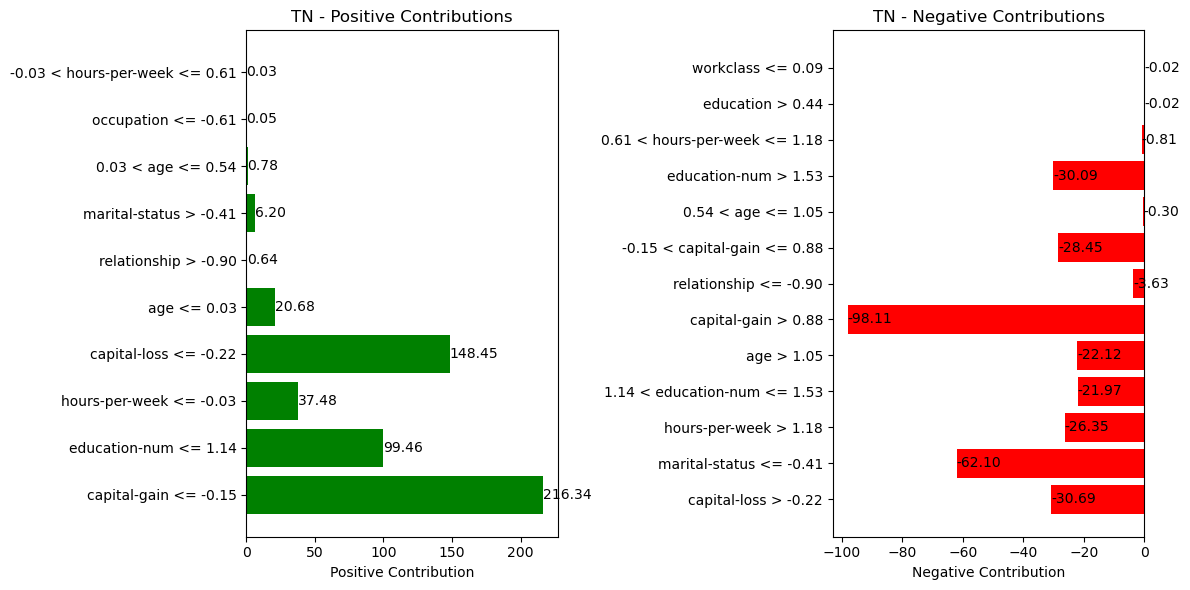


Visualizing Aggregated Contributions for FN:


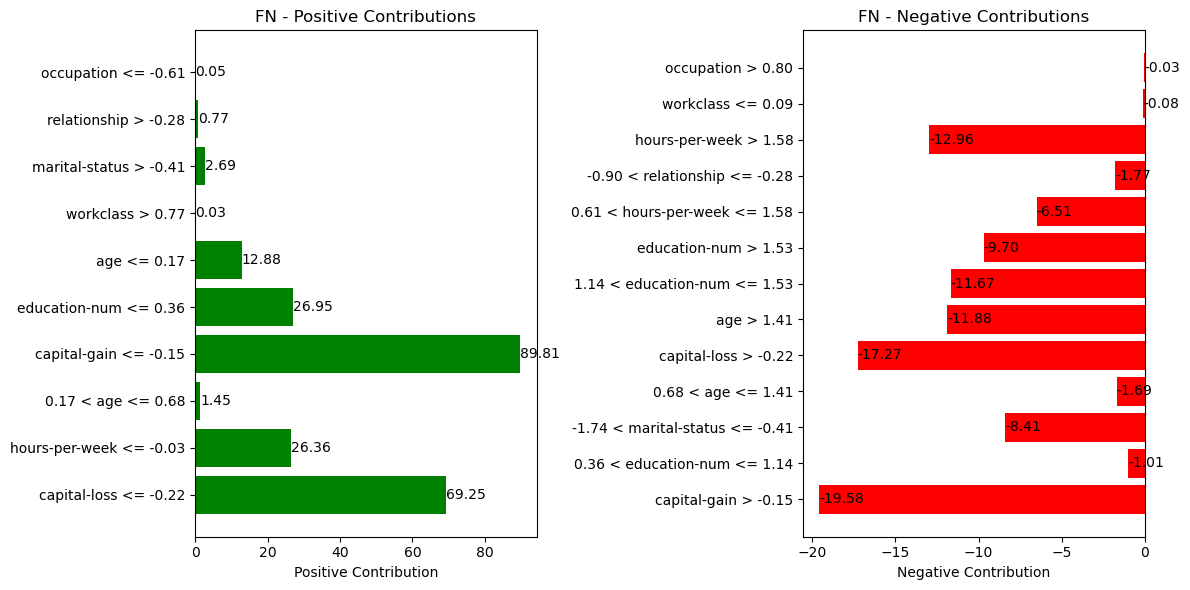

In [10]:
import matplotlib.pyplot as plt

def plot_aggregated_contributions(pos_contrib, neg_contrib, group_name):
    """
    Visualize aggregated positive and negative contributions using bar plots.
    """
    # Sort positive contributions
    pos_features = list(pos_contrib.keys())
    pos_values = list(pos_contrib.values())
    
    # Sort negative contributions
    neg_features = list(neg_contrib.keys())
    neg_values = list(neg_contrib.values())

    # Plot positive contributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(pos_features, pos_values, color='green')
    plt.xlabel('Positive Contribution')
    plt.title(f'{group_name} - Positive Contributions')

    # Add values to bars
    for i, v in enumerate(pos_values):
        plt.text(v, i, f'{v:.2f}', va='center')

    # Plot negative contributions
    plt.subplot(1, 2, 2)
    plt.barh(neg_features, neg_values, color='red')
    plt.xlabel('Negative Contribution')
    plt.title(f'{group_name} - Negative Contributions')

    # Add values to bars
    for i, v in enumerate(neg_values):
        plt.text(v, i, f'{v:.2f}', va='center')

    plt.tight_layout()
    plt.show()

# Visualize aggregated contributions for each group
print("\nVisualizing Aggregated Contributions for TN:")
plot_aggregated_contributions(pos_contrib_tn, neg_contrib_tn, "TN")

print("\nVisualizing Aggregated Contributions for FN:")
plot_aggregated_contributions(pos_contrib_fn, neg_contrib_fn, "FN")